# Init

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
# cd drive

In [ ]:
# cd MyDrive

In [ ]:
# cd Colab_Notebooks

In [ ]:
# cd Healthcare

# Preprocessing

## Read file

In [429]:
from sklearn.impute import SimpleImputer
import os
import os
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True, precision=20, threshold=10, linewidth=40)  # np禁止科学计数法显示
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # pd禁止科学计数法显示

In [430]:
path = "data/train_data.csv"

df_all = pd.read_csv(path)  # 读取数据，根据你自己文件地址编写

df_all.drop_duplicates(inplace=True)  # 使用drop_duplicates去重，inplace=True对原数据集进行替换
df_all.reset_index(drop=True, inplace=True)  # 删除数据后，恢复索引

df_all

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [431]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [432]:
df_all['Hospital_code'] = df_all['Hospital_code'].astype(object)
df_all['City_Code_Hospital'] = df_all['City_Code_Hospital'].astype(object)
df_all['Bed Grade'] = df_all['Bed Grade'].astype(object)
df_all['City_Code_Patient'] = df_all['City_Code_Patient'].astype(object)
df_all['Hospital_code'] = df_all['Hospital_code'].astype(float)
df_all['Available Extra Rooms in Hospital'] = df_all['Available Extra Rooms in Hospital'].astype(float)
df_all['patientid'] = df_all['patientid'].astype(float)
df_all['Visitors with Patient'] = df_all['Visitors with Patient'].astype(float)

In [433]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  float64
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  object 
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  float64
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  object 
 10  patientid                          318438 non-null  float64
 11  City_Code_Patient                  3139

In [434]:
# 定义查找缺失变量函数，返回 缺失值率> 指定缺失率(narate) 的列表
def filter_col_by_nan(data, narate=0.2):
    '''
    :param data: 查找数据集
    :param narate: 设定变量的缺失值率
    :return: 返回 缺失率>narate的变量名称列表
    '''
    n_samples = data.shape[0]
    list_nan_cols = []
    for col in data.columns:
        if data[col].isna().sum() / n_samples >= (narate):
            list_nan_cols.append(col)

    print(f'缺失量在{narate * 100}%以上的变量有:{list_nan_cols}')

    return list_nan_cols


list_nullfactor_todrop = filter_col_by_nan(df_all, narate=0.3)

df_select = df_all.drop(list_nullfactor_todrop, axis=1).copy()
df_select

缺失量在30.0%以上的变量有:[]


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8.00,c,3,Z,3.00,radiotherapy,R,F,2.00,31397.00,7.00,Emergency,Extreme,2.00,51-60,4911.00,0-10
1,2,2.00,c,5,Z,2.00,radiotherapy,S,F,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,5954.00,41-50
2,3,10.00,e,1,X,2.00,anesthesia,S,E,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,4745.00,31-40
3,4,26.00,b,2,Y,2.00,radiotherapy,R,D,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,7272.00,41-50
4,5,26.00,b,2,Y,2.00,radiotherapy,S,D,2.00,31397.00,7.00,Trauma,Extreme,2.00,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6.00,a,6,X,3.00,radiotherapy,Q,F,4.00,86499.00,23.00,Emergency,Moderate,3.00,41-50,4144.00,11-20
318434,318435,24.00,a,1,X,2.00,anesthesia,Q,E,4.00,325.00,8.00,Urgent,Moderate,4.00,81-90,6699.00,31-40
318435,318436,7.00,a,4,X,3.00,gynecology,R,F,4.00,125235.00,10.00,Emergency,Minor,3.00,71-80,4235.00,11-20
318436,318437,11.00,b,2,Y,3.00,anesthesia,Q,D,3.00,91081.00,8.00,Trauma,Minor,5.00,11-20,3761.00,11-20


## Data analysis

### Distribution of numeric independent variables

<Figure size 1080x576 with 0 Axes>

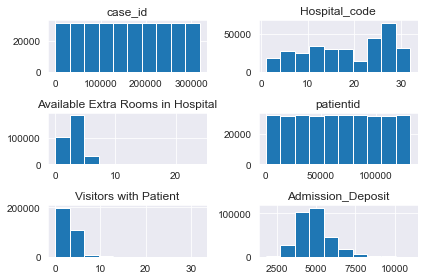

Skewness:


C:\Users\AORUS\AppData\Local\Temp\ipykernel_36784\1023588331.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_select.drop('Stay', axis=1).skew()


case_id                             -0.00
Hospital_code                       -0.28
City_Code_Hospital                   0.54
Available Extra Rooms in Hospital    0.97
Bed Grade                            0.05
patientid                            0.00
City_Code_Patient                    1.58
Visitors with Patient                3.14
Admission_Deposit                    0.93
dtype: float64

In [435]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 8))

df_select.drop('Stay', axis=1).hist()
plt.tight_layout()
plt.show()

print('Skewness:')
df_select.drop('Stay', axis=1).skew()

In [436]:
import seaborn as sns

### Univariate Analysis

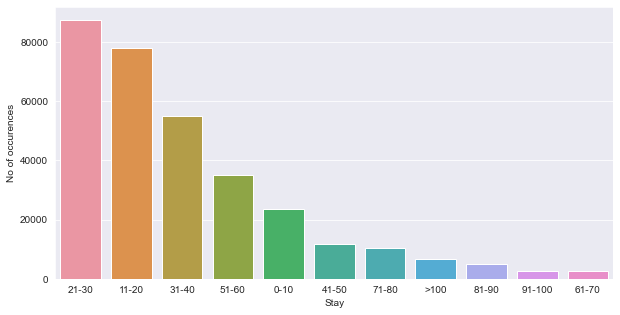

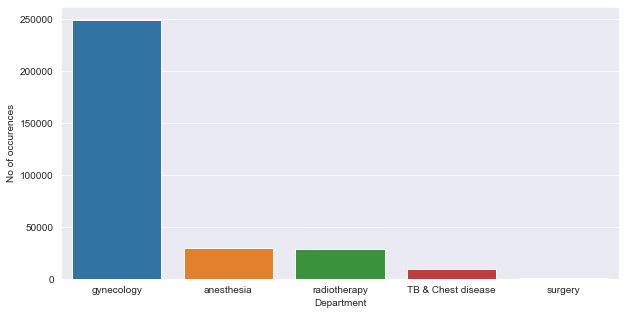

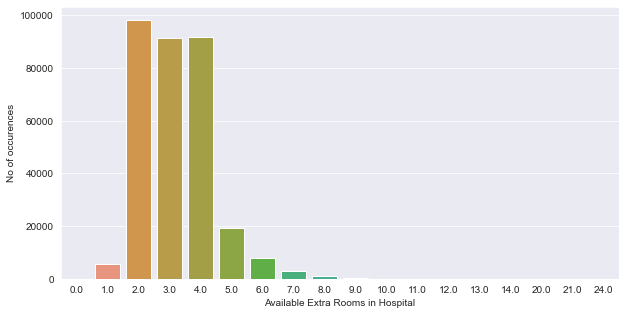

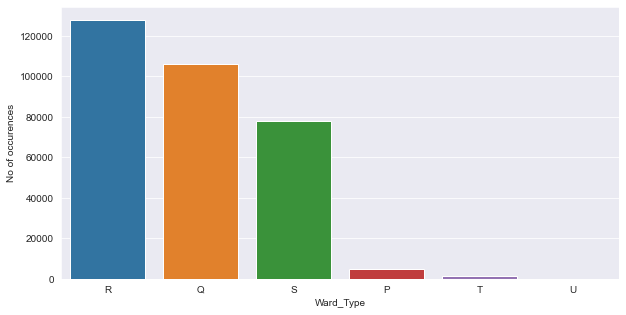

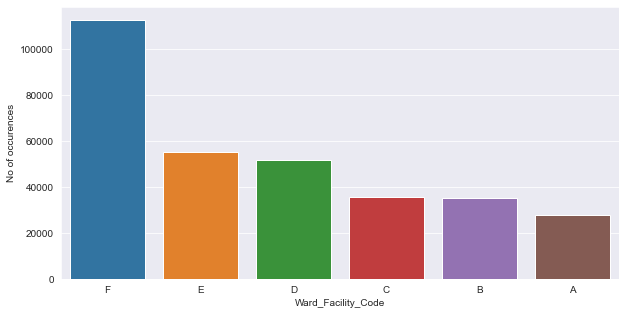

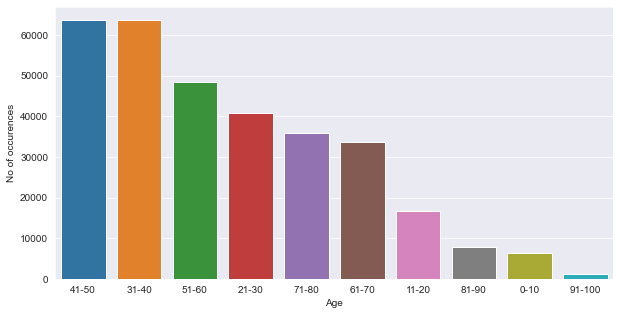

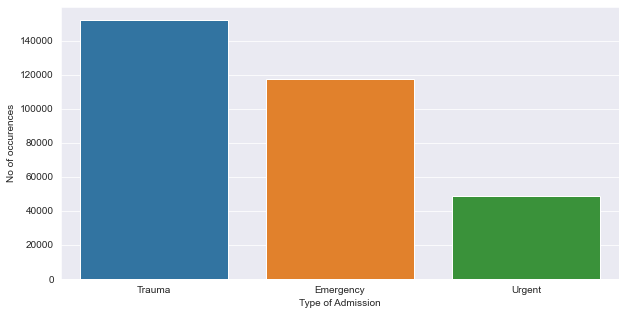

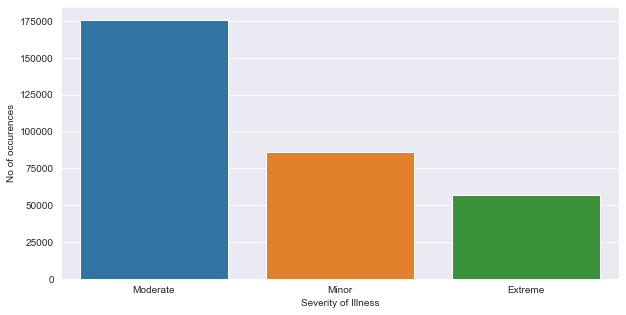

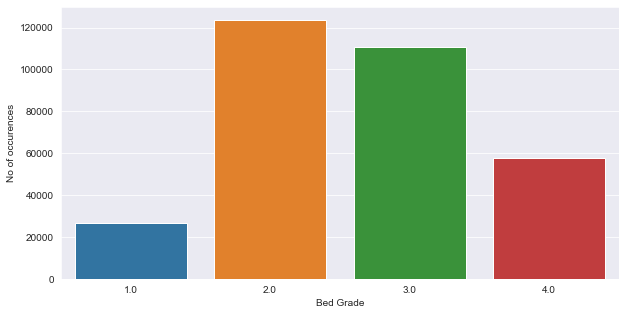

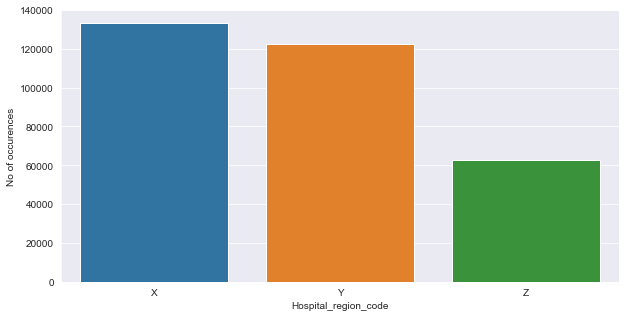

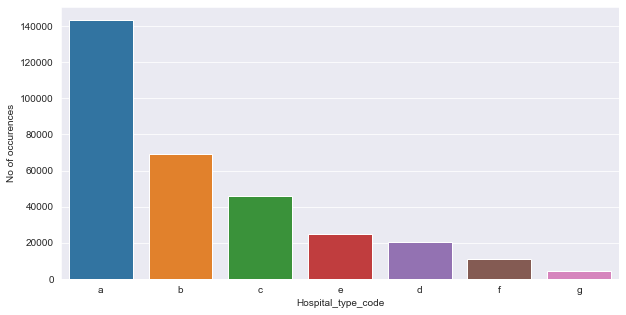

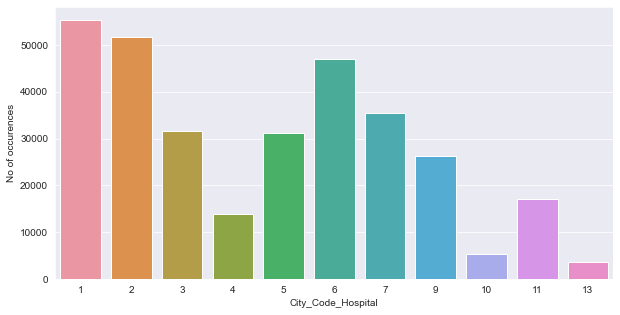

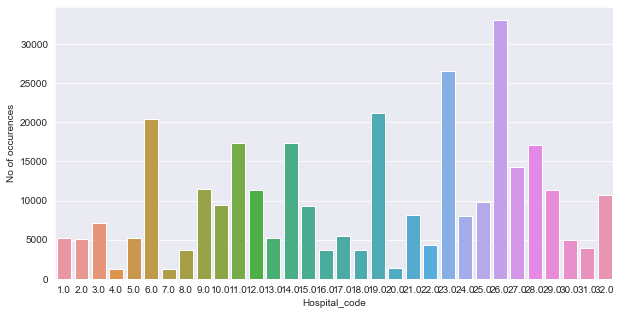

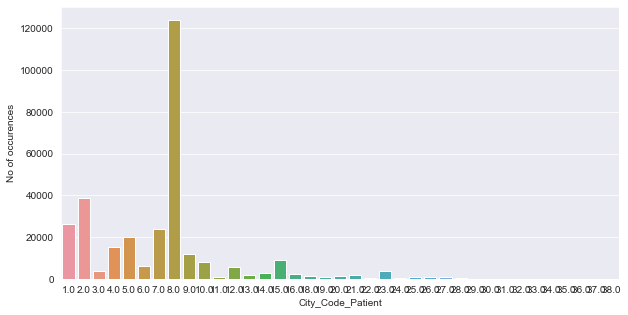

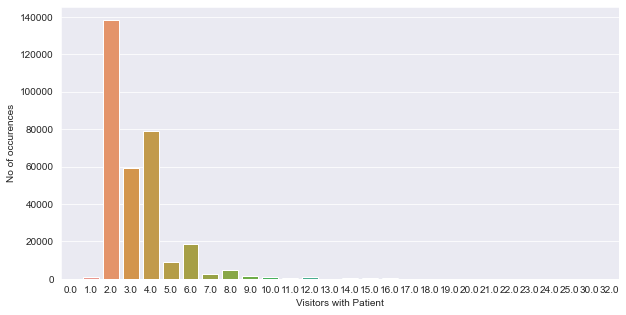

In [437]:
df_select['Stay'].replace('More than 100 Days', '>100', inplace=True)

for i in ['Stay', 'Department', 'Available Extra Rooms in Hospital', 'Ward_Type', 'Ward_Facility_Code', 'Age',
          'Type of Admission', 'Severity of Illness', 'Bed Grade', 'Hospital_region_code', 'Hospital_type_code',
          'City_Code_Hospital', 'Hospital_code', 'City_Code_Patient', 'Visitors with Patient']:
    count = df_select[i].value_counts()

    plt.figure(figsize=(10, 5))

    sns.barplot(x=count.index.values, y=count.values, data=df_select)

    plt.xlabel(i)
    plt.ylabel('No of occurences')

### Bivariate Analysis

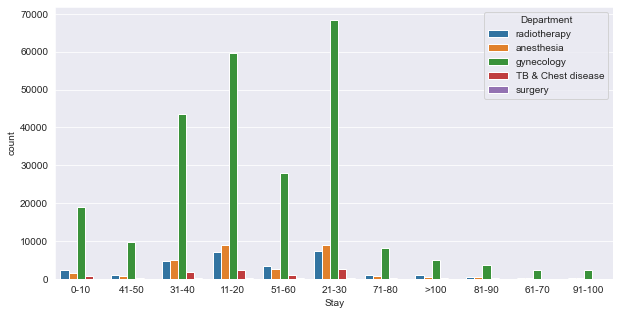

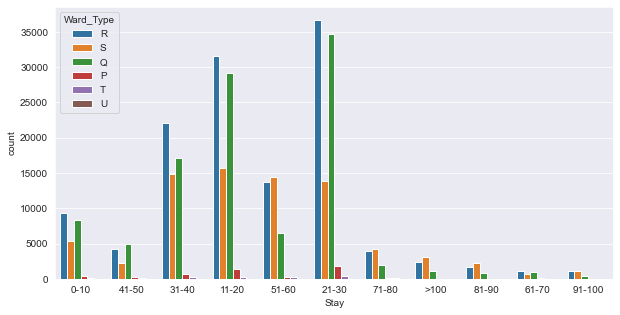

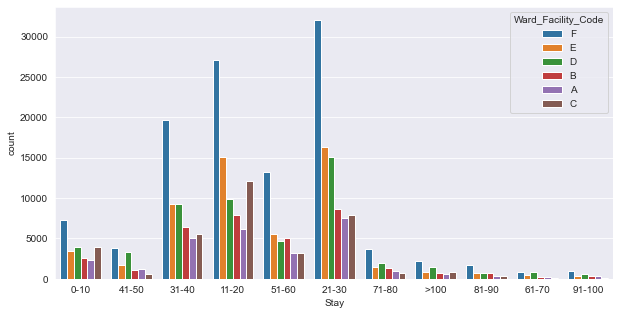

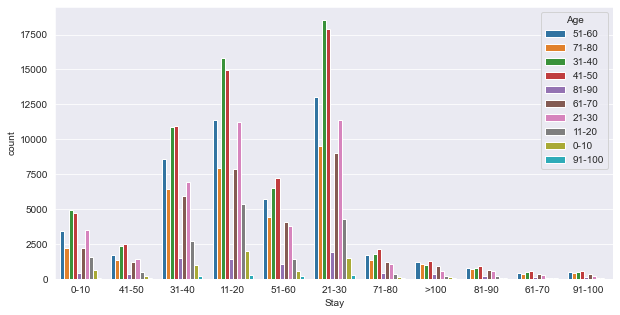

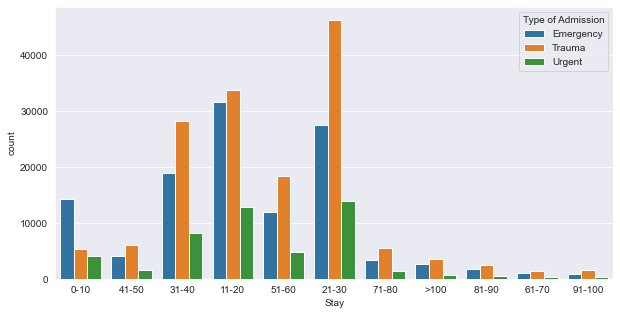

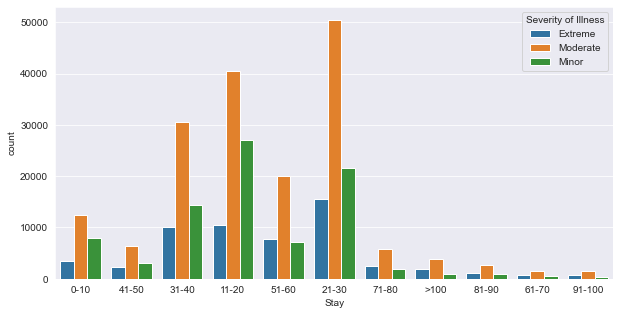

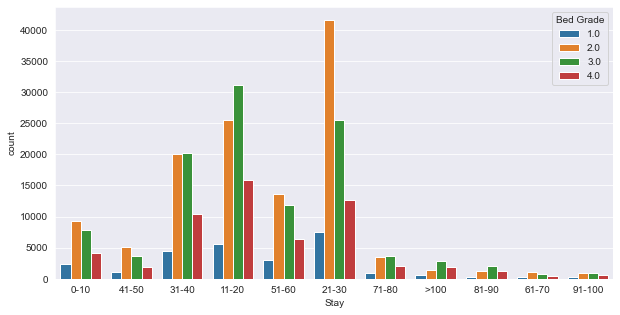

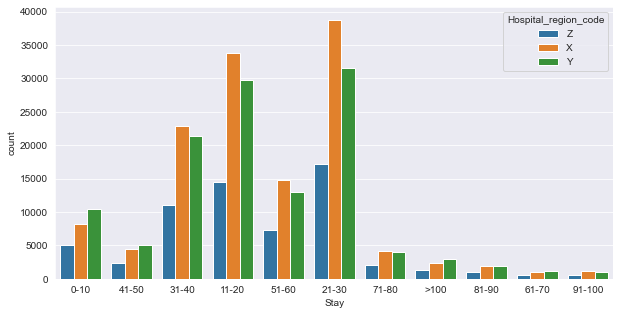

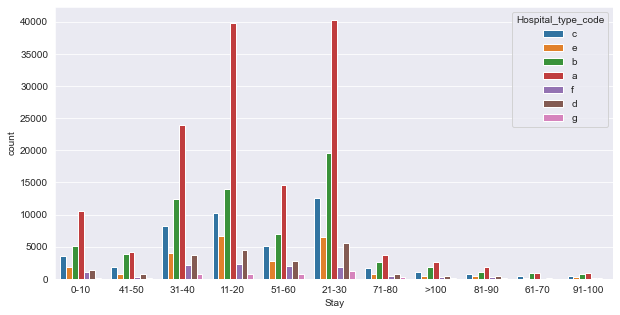

In [438]:

for i in ['Department', 'Ward_Type', 'Ward_Facility_Code', 'Age', 'Type of Admission', 'Severity of Illness',
          'Bed Grade', 'Hospital_region_code', 'Hospital_type_code']:
    plt.figure(figsize=(10, 5))

    sns.countplot(x='Stay', hue=i, data=df_select)

### Numerical Features

C:\Users\AORUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Admission_Deposit', ylabel='Density'>

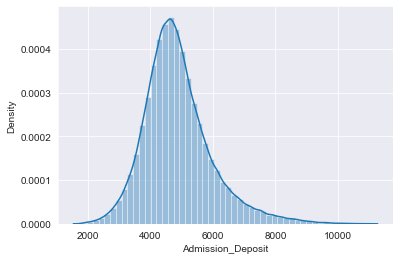

In [439]:
sns.distplot(df_select['Admission_Deposit'])

## Missing values

In [440]:
df_select.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [441]:
def impute_missing_values(data, columns):
    for column in columns:
        data[column] = data[column].fillna(data[column].value_counts().index[0])
        print(data[column].value_counts().index[0])

In [442]:
impute_columns = ['Bed Grade', 'City_Code_Patient']

impute_missing_values(df_select, impute_columns)

2.0
8.0


In [443]:

df_select.isnull().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

## Encoding

In [444]:
admission_encode = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
severity_encode = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

df_select['Type of Admission'] = df_select['Type of Admission'].map(admission_encode)
df_select['Severity of Illness'] = df_select['Severity of Illness'].map(severity_encode)

df_select['Age'] = df_select['Age'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10})

df_select['Stay'] = df_select['Stay'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10, '>100': 11})

# df_cat_train['Stay'] = df_cat_train['Stay'].astype(int)

In [445]:
onehot_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']


def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)

    return data

In [446]:
df_select

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8.00,c,3,Z,3.00,radiotherapy,R,F,2.00,31397.00,7.00,3,3,2.00,6,4911.00,1
1,2,2.00,c,5,Z,2.00,radiotherapy,S,F,2.00,31397.00,7.00,1,3,2.00,6,5954.00,5
2,3,10.00,e,1,X,2.00,anesthesia,S,E,2.00,31397.00,7.00,1,3,2.00,6,4745.00,4
3,4,26.00,b,2,Y,2.00,radiotherapy,R,D,2.00,31397.00,7.00,1,3,2.00,6,7272.00,5
4,5,26.00,b,2,Y,2.00,radiotherapy,S,D,2.00,31397.00,7.00,1,3,2.00,6,5558.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6.00,a,6,X,3.00,radiotherapy,Q,F,4.00,86499.00,23.00,3,2,3.00,5,4144.00,2
318434,318435,24.00,a,1,X,2.00,anesthesia,Q,E,4.00,325.00,8.00,2,2,4.00,9,6699.00,4
318435,318436,7.00,a,4,X,3.00,gynecology,R,F,4.00,125235.00,10.00,3,1,3.00,8,4235.00,2
318436,318437,11.00,b,2,Y,3.00,anesthesia,Q,D,3.00,91081.00,8.00,1,1,5.00,2,3761.00,2


In [447]:

data = onehot_encode(df_select, onehot_columns)
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,...,R,S,T,U,A,B,C,D,E,F
0,1,8.00,3,3.00,2.00,31397.00,7.00,3,3,2.00,...,1,0,0,0,0,0,0,0,0,1
1,2,2.00,5,2.00,2.00,31397.00,7.00,1,3,2.00,...,0,1,0,0,0,0,0,0,0,1
2,3,10.00,1,2.00,2.00,31397.00,7.00,1,3,2.00,...,0,1,0,0,0,0,0,0,1,0
3,4,26.00,2,2.00,2.00,31397.00,7.00,1,3,2.00,...,1,0,0,0,0,0,0,1,0,0
4,5,26.00,2,2.00,2.00,31397.00,7.00,1,3,2.00,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6.00,6,3.00,4.00,86499.00,23.00,3,2,3.00,...,0,0,0,0,0,0,0,0,0,1
318434,318435,24.00,1,2.00,4.00,325.00,8.00,2,2,4.00,...,0,0,0,0,0,0,0,0,1,0
318435,318436,7.00,4,3.00,4.00,125235.00,10.00,3,1,3.00,...,1,0,0,0,0,0,0,0,0,1
318436,318437,11.00,2,3.00,3.00,91081.00,8.00,1,1,5.00,...,0,0,0,0,0,0,0,1,0,0


<AxesSubplot:>

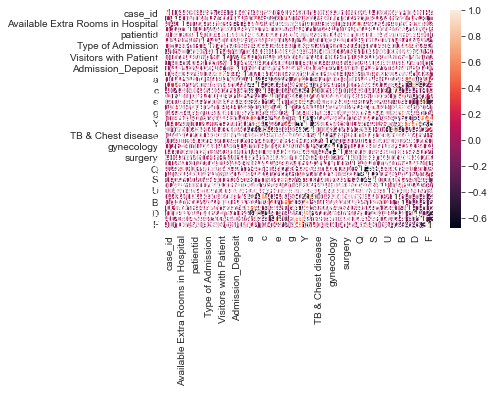

In [448]:
sns.heatmap(data.corr(), annot=True)

## Scaling

In [449]:
from sklearn.preprocessing import MinMaxScaler

In [450]:
data.set_index('case_id', inplace=True)

y = data['Stay']
X = data.drop(['Stay'], axis=1)

In [451]:
y

case_id
1         1
2         5
3         4
4         5
5         5
         ..
318434    2
318435    4
318436    2
318437    2
318438    1
Name: Stay, Length: 318438, dtype: int64

In [452]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [453]:
X

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
1,0.23,0.17,0.12,0.33,0.24,0.16,1.00,1.00,0.06,0.56,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.03,0.33,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0.29,0.00,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.81,0.08,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
5,0.81,0.08,0.08,0.33,0.24,0.16,0.00,1.00,0.06,0.56,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,0.16,0.42,0.12,1.00,0.66,0.59,1.00,0.50,0.09,0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
318435,0.74,0.00,0.08,1.00,0.00,0.19,0.50,0.50,0.12,0.89,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
318436,0.19,0.25,0.12,1.00,0.95,0.24,1.00,0.00,0.09,0.78,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


## Split dataset

In [454]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [455]:
# X = sm.add_constant(X)
X_all = X
Y_all = y
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, random_state=10, test_size=0.2)

In [456]:
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)
print(X_all.shape)
print(Y_all.shape)

(254750, 38)
(63688, 38)
(254750,)
(63688,)
(318438, 38)
(318438,)


In [457]:
Xtrain

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
54023,0.06,0.17,0.17,0.33,0.63,0.19,0.50,0.50,0.06,0.22,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
12007,0.71,0.42,0.08,1.00,0.26,0.19,0.00,0.00,0.06,0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1873,0.77,0.00,0.17,0.67,0.86,0.00,1.00,0.50,0.19,0.22,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.75,0.17,0.00,0.34,0.19,0.00,1.00,0.12,0.67,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
32848,0.77,0.00,0.17,0.33,0.69,0.03,0.00,0.50,0.12,0.56,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.58,0.50,0.12,0.33,0.93,0.19,1.00,0.00,0.12,0.33,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
9373,0.77,0.00,0.17,0.67,0.40,0.19,0.00,0.50,0.12,0.56,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
105596,0.58,0.50,0.08,0.33,0.40,0.19,1.00,0.50,0.12,0.44,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [458]:
Ytrain

case_id
54023     4
12007     3
1873      6
120504    3
32848     3
         ..
299742    2
9373      3
105596    4
93554     2
236670    2
Name: Stay, Length: 254750, dtype: int64

In [459]:
# K Fold Cross Validation
# from sklearn.model_selection import KFold,cross_val_score
# kfold=KFold(n_splits=10, shuffle=True, random_state=10)

## Feature Selection

In [575]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

In [461]:
# 1.构建RF模型
RFC_ = RFC()  # 随机森林
RFC().feature_importances_
permutation_importance

In [579]:
c = RFC_.fit(Xtrain, Ytrain).feature_importances_  # 特征重要性
print("重要性：")
c

KeyboardInterrupt: 

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# # 2. 交叉验证递归特征消除法
# selector = RFECV(RFC_, step=1, cv=10)  # 采用交叉验证，每次排除一个特征，筛选出最优特征
# selector = selector.fit(Xtrain, Ytrain)
# X_wrapper = selector.transform(Xtrain)  # 最优特征
# score = cross_val_score(RFC_, X_wrapper, Ytrain, cv=10).mean()  # 最优特征分类结果
# print(score)
# print("最佳数量和排序")
# print(selector.support_)  # 选取结果
# print(selector.n_features_)  # 选取特征数量
# print(selector.ranking_)  # 依次排数特征排序

In [ ]:
# print(score)
# print("最佳数量和排序")
# selector.support_  # 选取结果

In [ ]:
# 3.递归特征消除法
selector1 = RFE(RFC_, n_features_to_select=0.5, step=1).fit(Xtrain,
                                                            Ytrain)  # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征

In [ ]:

selector1.support_.sum()
print(selector1.ranking_)  # 特征排除排序
print(selector1.n_features_)  # 选择特征数量
X_wrapper1 = selector1.transform(Xtrain)  # 最优特征
score = cross_val_score(RFC_, X_wrapper1, Ytrain, cv=3).mean()
score

In [ ]:
selector1.n_features_  # 选取特征数量

In [ ]:
selector1.ranking_

In [ ]:
support_cat_list = selector1.support_

In [462]:
support_cat_list = [True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    True,
                    True,
                    True,
                    False,
                    False,
                    True,
                    True,
                    True,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    True]
support_cat_list

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

In [463]:
# # 4.递归特征消除法和曲线图选取最优特征数量
# score = []  # 建立列表
# for i in range(1, 17, 1):
#     X_wrapper = RFE(RFC_, n_features_to_select=i, step=1).fit_transform(Xtrain, Ytrain)  # 最优特征
#     once = cross_val_score(RFC_, X_wrapper, Ytrain, cv=9).mean()  # 交叉验证
#     score.append(once)  # 交叉验证结果保存到列表
# print(max(score), (score.index(max(score)) * 1) + 1)  # 输出最优分类结果和对应的特征数量
# print(score)
# plt.figure(figsize=[20, 5])
# plt.plot(range(1, 17, 1), score)
# plt.xticks(range(1, 17, 1))
# plt.show()

In [464]:
# RFE.ranking_

In [465]:
columns_list = list(Xtrain.columns)

In [466]:
list_factor_todrop = []
for i in range(38):
    if support_cat_list[i] is False:
        list_factor_todrop.append(columns_list[i])

list_factor_todrop  #需要抛弃的变量

['b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'X',
 'Y',
 'Z',
 'TB & Chest disease',
 'surgery',
 'P',
 'T',
 'U',
 'A',
 'B',
 'C',
 'D',
 'E']

In [467]:
Xtrain.drop(list_factor_todrop, axis=1, inplace=True)
Xtest.drop(list_factor_todrop, axis=1, inplace=True)
X_all.drop(list_factor_todrop, axis=1, inplace=True)

In [468]:
Xtrain

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,,,,,
54023,0.06,0.17,0.17,0.33,0.63,0.19,0.50,0.50,0.06,0.22,0.31,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.71,0.42,0.08,1.00,0.26,0.19,0.00,0.00,0.06,0.44,0.49,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.77,0.00,0.17,0.67,0.86,0.00,1.00,0.50,0.19,0.22,0.19,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.75,0.17,0.00,0.34,0.19,0.00,1.00,0.12,0.67,0.43,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.77,0.00,0.17,0.33,0.69,0.03,0.00,0.50,0.12,0.56,0.27,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.58,0.50,0.12,0.33,0.93,0.19,1.00,0.00,0.12,0.33,0.34,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.77,0.00,0.17,0.67,0.40,0.19,0.00,0.50,0.12,0.56,0.38,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.58,0.50,0.08,0.33,0.40,0.19,1.00,0.50,0.12,0.44,0.26,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [469]:
Ytrain

case_id
54023     4
12007     3
1873      6
120504    3
32848     3
         ..
299742    2
9373      3
105596    4
93554     2
236670    2
Name: Stay, Length: 254750, dtype: int64

# Train and Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion='entropy', random_state=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)
accuracy_score(Ytest, y_pred_DT) * 100

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Ytest, y_pred_DT))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_DT, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Decision Tree with HyperParameter adjustment

In [ ]:
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV

paramGrid = dict(
    max_depth=range(15),
    criterion=["gini", "entropy"])
dtModel = DecisionTreeClassifier(random_state=10)
grid = GridSearchCV(dtModel, paramGrid, cv=10, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [ ]:
print(grid.best_params_)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion='gini', random_state=10, max_depth=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)
accuracy_score(Ytest, y_pred_DT) * 100

In [ ]:
print(classification_report(Ytest, y_pred_DT))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_DT, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Random Forest with HyperParameter adjustment

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

paramGrid = dict(
    n_estimators=np.linspace(10, 100, 10).astype(int),
    max_depth=np.arange(4, 11))
rfModel = RandomForestClassifier(random_state=10)
grid = GridSearchCV(rfModel, paramGrid, cv=10, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [ ]:
rf_classification = RandomForestClassifier(random_state=10, max_depth=10, n_estimators=100)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest, y_pred_RF) * 100

In [ ]:
print(classification_report(Ytest, y_pred_RF))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_RF, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [ ]:
# from mlxtend.classifier import LogisticRegression as LR
# from sklearn.metrics import accuracy_score

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
#
# paramGrid = dict(
#     penalty=['l1', 'l2'],
#     C=[0.1, 1, 10, 100, 1000])
# lrModel = LogisticRegression(random_state=10)
# grid = GridSearchCV(lrModel, paramGrid, cv=3, return_train_score=True)
# grid.fit(Xtrain, Ytrain)
# print(grid.best_params_)

In [ ]:
# LR = LogisticRegression(fit_intercept=True, C=10, penalty="l2")
#
# LR.fit(Xtrain, Ytrain)
#
# y_pred_LR = LR.predict(Xtest)
# accuracy_score(Ytest, y_pred_LR) * 100

In [ ]:
# print(classification_report(Ytest, y_pred_LR))

In [ ]:
# from sklearn import metrics
#
# fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_LR, pos_label=11)
# auc = metrics.auc(fpr, tpr)
# auc

In [ ]:
# import matplotlib.pyplot as plt
#
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

## Support Vector Classification

In [ ]:
from sklearn.svm import SVC

In [ ]:

paramGrid = dict(
    kernel=['linear'],
    C=[0.001, 0.01, 0.1, 1, 10, 100],
    gamma=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
svmModel = SVC()
grid = GridSearchCV(svmModel, paramGrid, cv=3, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [ ]:
svc = SVC(kernel="linear", C=10, gamma=1)

svc.fit(Xtrain, Ytrain)

y_pred_SVC = svc.predict(Xtest)
accuracy_score(Ytest, y_pred_SVC) * 100

In [ ]:
print(classification_report(Ytest, y_pred_SVC))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_SVC, pos_label=2)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Gradient boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=10)

GB.fit(Xtrain, Ytrain)
y_pred_GB = GB.predict(Xtest)
accuracy_score(Ytest, y_pred_GB) * 100

In [ ]:
print(classification_report(Ytest, y_pred_GB))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_GB, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

In [470]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(Xtrain, Ytrain)

y_pred_NB = NB.predict(Xtest)
accuracy_score(Ytest, y_pred_NB) * 100

34.877841979650796

In [471]:
print(classification_report(Ytest, y_pred_NB))

              precision    recall  f1-score   support

           1       0.25      0.15      0.19      4805
           2       0.36      0.35      0.36     15569
           3       0.39      0.62      0.48     17460
           4       0.29      0.12      0.17     11083
           5       0.05      0.00      0.01      2321
           6       0.30      0.49      0.37      6944
           7       0.00      0.00      0.00       545
           8       0.14      0.02      0.03      2073
           9       0.09      0.01      0.02      1010
          10       0.17      0.00      0.00       562
          11       0.32      0.36      0.34      1316

    accuracy                           0.35     63688
   macro avg       0.21      0.19      0.18     63688
weighted avg       0.31      0.35      0.31     63688



In [472]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_NB, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

0.8718276671961563

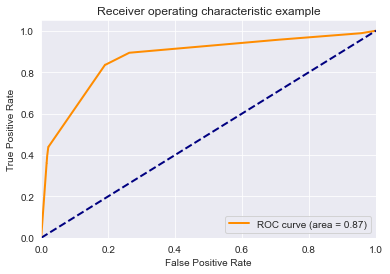

In [473]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [474]:
Xtrain

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,,,,,
54023,0.06,0.17,0.17,0.33,0.63,0.19,0.50,0.50,0.06,0.22,0.31,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.71,0.42,0.08,1.00,0.26,0.19,0.00,0.00,0.06,0.44,0.49,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.77,0.00,0.17,0.67,0.86,0.00,1.00,0.50,0.19,0.22,0.19,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.75,0.17,0.00,0.34,0.19,0.00,1.00,0.12,0.67,0.43,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.77,0.00,0.17,0.33,0.69,0.03,0.00,0.50,0.12,0.56,0.27,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.58,0.50,0.12,0.33,0.93,0.19,1.00,0.00,0.12,0.33,0.34,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.77,0.00,0.17,0.67,0.40,0.19,0.00,0.50,0.12,0.56,0.38,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.58,0.50,0.08,0.33,0.40,0.19,1.00,0.50,0.12,0.44,0.26,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [524]:
from sklearn.preprocessing import KBinsDiscretizer
Xtrain_num = Xtrain[['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']]
Xtrain_cat = Xtrain.drop(['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'], axis=1)
Xtest_num = Xtest[['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']]
Xtest_cat = Xtest.drop(['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'], axis=1)
kbs = KBinsDiscretizer(n_bins=5, encode='onehot').fit(Xtrain_num)

Xtrain_cat

C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


,Hospital_code,City_Code_Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Age,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,,
54023,0.06,0.17,0.33,0.63,0.19,0.50,0.50,0.22,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.71,0.42,1.00,0.26,0.19,0.00,0.00,0.44,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.77,0.00,0.67,0.86,0.00,1.00,0.50,0.22,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.75,0.00,0.34,0.19,0.00,1.00,0.67,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.77,0.00,0.33,0.69,0.03,0.00,0.50,0.56,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.58,0.50,0.33,0.93,0.19,1.00,0.00,0.33,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.77,0.00,0.67,0.40,0.19,0.00,0.50,0.56,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.58,0.50,0.33,0.40,0.19,1.00,0.50,0.44,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [525]:
Xtrain_num

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
54023,0.17,0.06,0.31
12007,0.08,0.06,0.49
1873,0.17,0.19,0.19
120504,0.17,0.12,0.43
32848,0.17,0.12,0.27
...,...,...,...
299742,0.12,0.12,0.34
9373,0.17,0.12,0.38
105596,0.08,0.12,0.26


In [526]:
Xtrain_num_1 = pd.cut(Xtrain_num['Available Extra Rooms in Hospital'], 5, labels=False)
Xtrain_num_2 = pd.cut(Xtrain_num['Visitors with Patient'], 5, labels=False)
Xtrain_num_3 = pd.cut(Xtrain_num['Admission_Deposit'], 5, labels=False)

Xtest_num_1 = pd.cut(Xtest_num['Available Extra Rooms in Hospital'], 5, labels=False)
Xtest_num_2 = pd.cut(Xtest_num['Visitors with Patient'], 5, labels=False)
Xtest_num_3 = pd.cut(Xtest_num['Admission_Deposit'], 5, labels=False)

Xtrain_NB = pd.merge(Xtrain_num_1, Xtrain_num_2, left_index=True, right_index=True)
Xtrain_NB = pd.merge(Xtrain_NB, Xtrain_num_3, left_index=True, right_index=True)

Xtest_NB = pd.merge(Xtest_num_1, Xtest_num_2, left_index=True, right_index=True)
Xtest_NB = pd.merge(Xtest_NB, Xtest_num_3, left_index=True, right_index=True)

In [527]:
Xtrain_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
54023,0,0,1
12007,0,0,2
1873,0,0,0
120504,0,0,2
32848,0,0,1
...,...,...,...
299742,0,0,1
9373,0,0,1
105596,0,0,1


In [528]:
Xtest_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
304487,0,0,1
315373,0,0,2
158272,1,0,2
3609,1,0,1
13537,0,0,2
...,...,...,...
294067,0,0,1
77724,0,0,1
187546,1,0,1


In [529]:
Xtrain_NB = pd.DataFrame(scaler.fit_transform(Xtrain_NB), index=Xtrain_NB.index, columns=Xtrain_NB.columns)
Xtest_NB = pd.DataFrame(scaler.fit_transform(Xtest_NB), index=Xtest_NB.index, columns=Xtest_NB.columns)

In [530]:
Xtrain_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
case_id,,,
54023,0.00,0.00,0.25
12007,0.00,0.00,0.50
1873,0.00,0.00,0.00
120504,0.00,0.00,0.50
32848,0.00,0.00,0.25
...,...,...,...
299742,0.00,0.00,0.25
9373,0.00,0.00,0.25
105596,0.00,0.00,0.25


In [531]:
Xtrain_cat

,Hospital_code,City_Code_Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Age,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,,
54023,0.06,0.17,0.33,0.63,0.19,0.50,0.50,0.22,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.71,0.42,1.00,0.26,0.19,0.00,0.00,0.44,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.77,0.00,0.67,0.86,0.00,1.00,0.50,0.22,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.75,0.00,0.34,0.19,0.00,1.00,0.67,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.77,0.00,0.33,0.69,0.03,0.00,0.50,0.56,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.58,0.50,0.33,0.93,0.19,1.00,0.00,0.33,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.77,0.00,0.67,0.40,0.19,0.00,0.50,0.56,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.58,0.50,0.33,0.40,0.19,1.00,0.50,0.44,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [532]:
Xtrain_NB = pd.merge(Xtrain_NB, Xtrain_cat, left_index=True, right_index=True)
Xtest_NB = pd.merge(Xtest_NB, Xtest_cat, left_index=True, right_index=True)

In [533]:
Xtrain_NB

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Hospital_code,City_Code_Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Age,a,anesthesia,gynecology,radiotherapy,Q,R,S,F
case_id,,,,,,,,,,,,,,,,,,,
54023,0.00,0.00,0.25,0.06,0.17,0.33,0.63,0.19,0.50,0.50,0.22,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
12007,0.00,0.00,0.50,0.71,0.42,1.00,0.26,0.19,0.00,0.00,0.44,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
1873,0.00,0.00,0.00,0.77,0.00,0.67,0.86,0.00,1.00,0.50,0.22,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
120504,0.00,0.00,0.50,0.00,0.75,0.00,0.34,0.19,0.00,1.00,0.67,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
32848,0.00,0.00,0.25,0.77,0.00,0.33,0.69,0.03,0.00,0.50,0.56,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299742,0.00,0.00,0.25,0.58,0.50,0.33,0.93,0.19,1.00,0.00,0.33,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9373,0.00,0.00,0.25,0.77,0.00,0.67,0.40,0.19,0.00,0.50,0.56,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
105596,0.00,0.00,0.25,0.58,0.50,0.33,0.40,0.19,1.00,0.50,0.44,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


In [550]:
from sklearn.naive_bayes import CategoricalNB

mnb = CategoricalNB().fit(Xtrain_NB, Ytrain)

In [551]:
y_pred_NB = mnb.predict(Xtest_NB)

In [552]:
accuracy_score(Ytest, y_pred_NB) * 100

29.247267931164426

## KNN with HyperParameter adjustment

In [554]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

paramGrid = dict(
    n_neighbors=[10, 50, 300, 500, 1000],
    weights=["uniform", "distance"])
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, paramGrid, cv=3, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [572]:
knn = KNeighborsClassifier(n_neighbors=300, weights='distance')
knn.fit(Xtrain, Ytrain)
y_pred_KNN = knn.predict(Xtest)
accuracy_score(Ytest, y_pred_KNN) * 100

31.95107398568019

In [573]:
print(classification_report(Ytest, y_pred_NB))

              precision    recall  f1-score   support

           1       0.17      0.00      0.00      4805
           2       0.30      0.34      0.32     15569
           3       0.32      0.63      0.43     17460
           4       0.15      0.00      0.00     11083
           5       0.00      0.00      0.00      2321
           6       0.20      0.33      0.25      6944
           7       0.00      0.00      0.00       545
           8       0.00      0.00      0.00      2073
           9       0.00      0.00      0.00      1010
          10       0.00      0.00      0.00       562
          11       0.17      0.00      0.01      1316

    accuracy                           0.29     63688
   macro avg       0.12      0.12      0.09     63688
weighted avg       0.23      0.29      0.22     63688



C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AORUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [568]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_KNN, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

0.7468228914579979

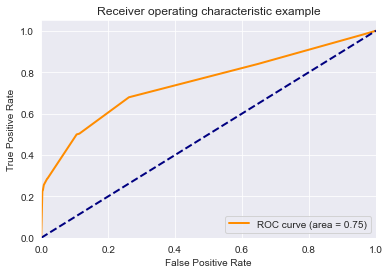

In [569]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## CATBoost

In [ ]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(random_state=10, use_best_model=True, iterations=1000)
cb.fit(Xtrain, Ytrain, use_best_model=True, verbose=100, eval_set=(Xtest, Ytest))

In [ ]:
cb_pred_test = cb.predict(Xtest)
accuracy_score(Ytest, cb_pred_test) * 100

In [ ]:
print(classification_report(Ytest, cb_pred_test))

In [ ]:
cb_pred_train = cb.predict(Xtrain)
accuracy_score(Ytrain, cb_pred_train) * 100

In [ ]:
print(classification_report(Ytrain, cb_pred_train))

In [ ]:
cb_pred_all = cb.predict(X_all)
accuracy_score(Y_all, cb_pred_all) * 100

In [ ]:
print(classification_report(Y_all, cb_pred_all))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, cb_pred_all, pos_label=2)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Neural Netowrk

In [ ]:
import torch
import torch.nn as nn
import math

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# define model to tackle this single-label, binary classification problem
model = Sequential()
model.add(Dense(38, input_dim=Xtrain.shape[1], activation='relu'))
model.add(Dense(38, activation='relu'))
model.add(Dense(38, activation='relu'))
model.add(Dense(38, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
X_train = np.asarray(Xtrain)
y_train = np.asarray(Ytrain)
model.fit(X_train, y_train, validation_split=0.2, batch_size=225, epochs=5, shuffle=True, verbose=2)

# _, accuracy = model_base.evaluate(x_train, y_test, verbose=0)
# print('Accuracy: %.2f' % (accuracy*100))
# monitor = EarlyStopping(monitor = '??', min_delta = ?)
# checkpointer = ModelCheckPoint(filepath = 'DIR', verbose = 0, save_best_only= True)